In [2]:
from typing_extensions import TypedDict

class State(TypedDict):
    """
    A class representing a state with a name and a value.
    """
    name: str
    value: str

In [4]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict
from pydantic import BaseModel

class OverallState(BaseModel):
    a:str

In [8]:
def node(state: OverallState):
    
    return {"a":"Hi I am Aman"}

builder  = StateGraph(OverallState)
builder.add_node(node)
builder.add_edge(START, "node")
builder.add_edge("node", END)
graph = builder.compile()

In [9]:
graph.invoke({"a":"Hello"})

{'a': 'Hi I am Aman'}

In [13]:
try:
    graph.invoke({"a":123})
except Exception as e:
    print("Exception was raised because the input was not a string")


## Multiple Nodes- Run time validation

Run-time validation will also work in a multi-node graph. In the example below bad_node updates a to an integer.

Because run-time validation occurs on inputs, the validation error will occur when ok_node is called (not when bad_node returns an update to the state which is inconsistent with the schema).

In [37]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict
from pydantic import BaseModel

class OverallState(BaseModel):
    a:str
    
def bad_node(state: OverallState):
    return {"a":123}  # This should be a string, but it's an int

def ok_node(state: OverallState):
    return {"a":"Goodbye"}  # This is a valid string

builder = StateGraph(OverallState)
builder.add_node(bad_node)
builder.add_node(ok_node)
builder.add_edge(START, "bad_node")
builder.add_edge("bad_node", "ok_node")
builder.add_edge("ok_node", END)
graph = builder.compile()

In [38]:
graph.invoke({"a":"Aman"})  

{'a': 'Goodbye'}

In [39]:
try:
    graph.invoke({"a": "krish"})
except Exception as e:
    print("An exception was raised because bad_node sets `a` to an integer.")
    print(e)

### Prompt Chaining
Prompt chaining decomposes a task into a sequence of steps, where each LLM call processes the output of the previous one. You can add programmatic checks on any intermediate steps to ensure that the process is still on track.

When to use this workflow: This workflow is ideal for situations where the task can be easily and cleanly decomposed into fixed subtasks. The main goal is to trade off latency for higher accuracy, by making each LLM call an easier task.

![WhatsApp Image 2025-05-17 at 16.17.12_8430e0a2.jpg](<attachment:WhatsApp Image 2025-05-17 at 16.17.12_8430e0a2.jpg>)
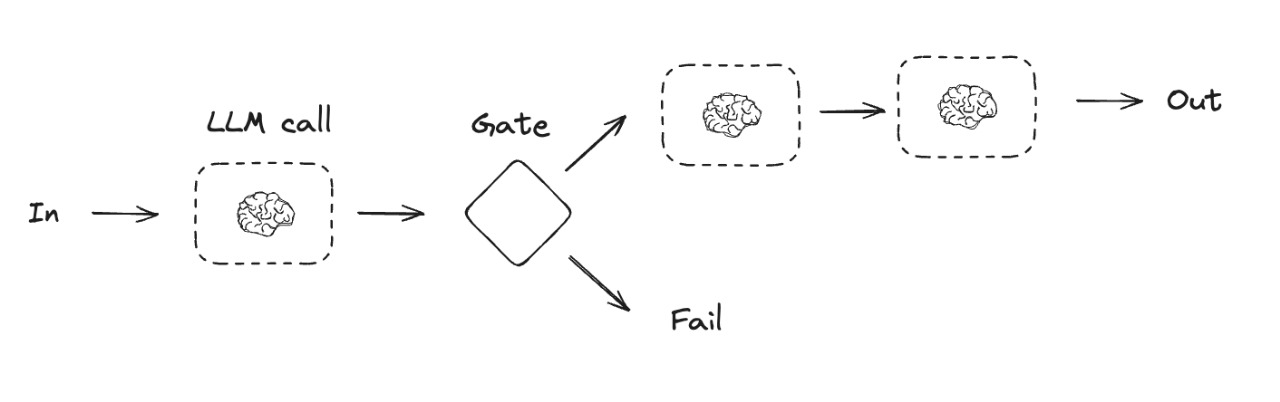

In [40]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


llm=ChatGroq(model="llama3-70b-8192")
#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result

AIMessage(content="Hello! It's nice to meet you. Is there something I can help you with, or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 11, 'total_tokens': 37, 'completion_time': 0.074285714, 'prompt_time': 0.000121629, 'queue_time': 0.060319291000000004, 'total_time': 0.074407343}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_dd4ae1c591', 'finish_reason': 'stop', 'logprobs': None}, id='run-c1377141-1fce-4bbb-a6de-cd79c41d93d7-0', usage_metadata={'input_tokens': 11, 'output_tokens': 26, 'total_tokens': 37})

In [41]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

class State(TypedDict):
    topic:str
    joke:str
    improved_joke:str
    final_joke:str
    
    

In [42]:
# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}

def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Fail"
    return "Pass"

def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}

def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}



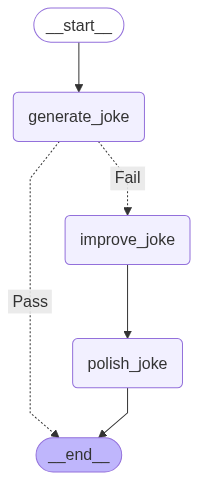

In [43]:
# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges("generate_joke",check_punchline,{"Fail":"improve_joke","Pass":END})
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

In [44]:
state = chain.invoke({"topic":"cats"})

In [45]:
state

{'topic': 'cats',
 'joke': 'Why did the cat join a band?\n\nBecause it wanted to be the purr-cussionist!',
 'improved_joke': 'You\'ve already got a great start with the "purr-cussionist" pun! Here\'s a revised version with some additional wordplay:\n\nWhy did the cat join a band?\n\nBecause it wanted to be the purr-cussionist and have a claw-some time making some mew-sic! The crowd was paws-itively entranced by its whisker-ific beats!\n\nThe added wordplay includes:\n\n* "claw-some" instead of "awesome"\n* "mew-sic" instead of "music"\n* "paws-itive" instead of "positive" (implied by "paws-itively")\n* "whisker-ific" instead of "terrific"\n\nFeel free to modify or add to these puns to make it even more fur-tastic!',
 'final_joke': 'Thank you for the encouragement! Here\'s a revised version with a surprising twist:\n\nWhy did the cat join a band?\n\nBecause it wanted to be the purr-cussionist and have a claw-some time making some mew-sic! The crowd was paws-itively entranced by its whis

In [46]:
print(state["joke"])

Why did the cat join a band?

Because it wanted to be the purr-cussionist!


In [47]:
print(state["improved_joke"])

You've already got a great start with the "purr-cussionist" pun! Here's a revised version with some additional wordplay:

Why did the cat join a band?

Because it wanted to be the purr-cussionist and have a claw-some time making some mew-sic! The crowd was paws-itively entranced by its whisker-ific beats!

The added wordplay includes:

* "claw-some" instead of "awesome"
* "mew-sic" instead of "music"
* "paws-itive" instead of "positive" (implied by "paws-itively")
* "whisker-ific" instead of "terrific"

Feel free to modify or add to these puns to make it even more fur-tastic!


In [48]:
print(state["final_joke"])

Thank you for the encouragement! Here's a revised version with a surprising twist:

Why did the cat join a band?

Because it wanted to be the purr-cussionist and have a claw-some time making some mew-sic! The crowd was paws-itively entranced by its whisker-ific beats! But little did they know, the cat's true talent was in... quantum purr-ysics! It could entangle drumbeats with the fabric of space-time, making the audience purr-ceive time dilation and gravitational waves in every rhythm!

The surprising twist adds a layer of sci-fi humor, playing on the concept of quantum physics and its mind-bending principles. The added wordplay includes:

* "quantum purr-ysics" instead of "quantum physics"
* "purr-ceive" instead of "perceive"
* "purr-ceive time dilation" instead of "perceive time dilation" (implied by "purr-ceive")

Let me know if you'd like me to modify or add to these puns to make it even more fur-tastic!


In [49]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

class State(TypedDict):
    question:str
    review:str
    testcase:str
    runtest:str
    analysefailedtest:str
    givesummary:str
def coder():
    """First LLM call to generate initial Code for mentioned question"""

    msg = llm.invoke(f"Write a code asked in mentioned question {state['question']}")
    return {"question": msg.content}

### Parallelization¶
With parallelization, LLMs work simultaneously on a task:

LLMs can sometimes work simultaneously on a task and have their outputs aggregated programmatically. This workflow, parallelization, manifests in two key variations: Sectioning: Breaking a task into independent subtasks run in parallel. Voting: Running the same task multiple times to get diverse outputs.

When to use this workflow: Parallelization is effective when the divided subtasks can be parallelized for speed, or when multiple perspectives or attempts are needed for higher confidence results. For complex tasks with multiple considerations, LLMs generally perform better when each consideration is handled by a separate LLM call, allowing focused attention on each specific aspect.
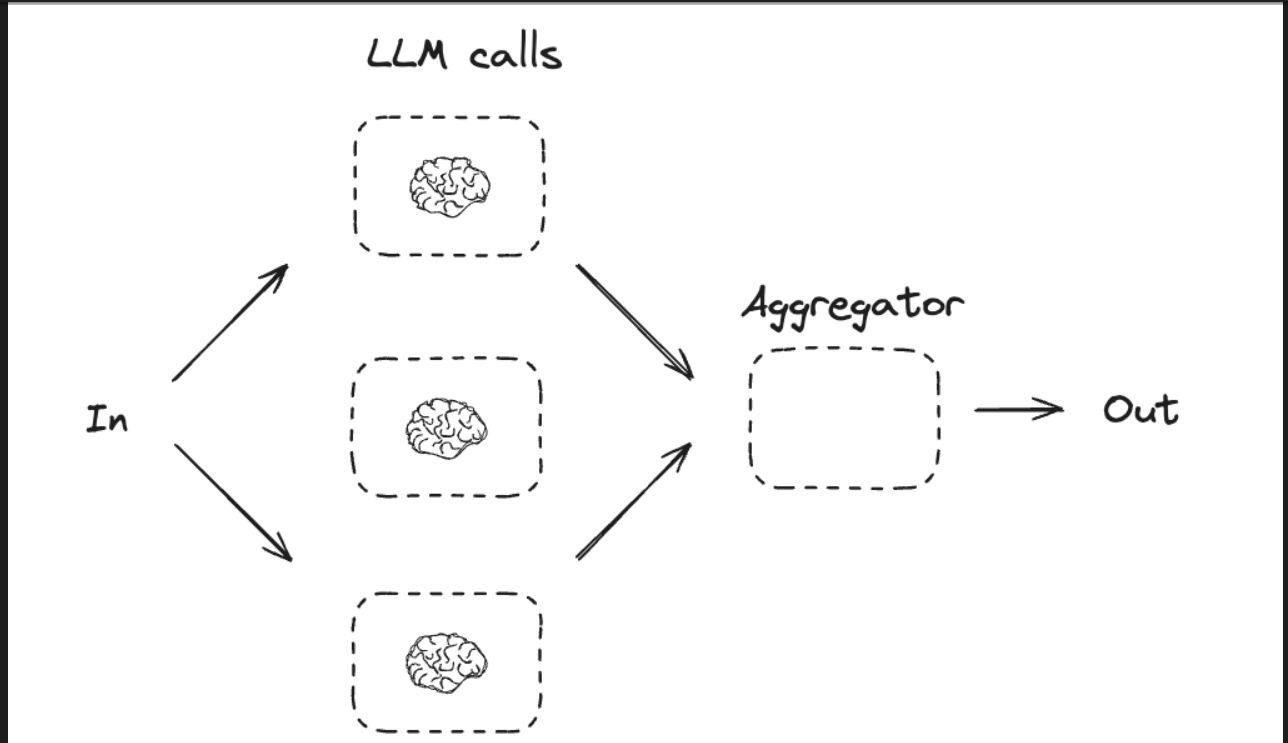

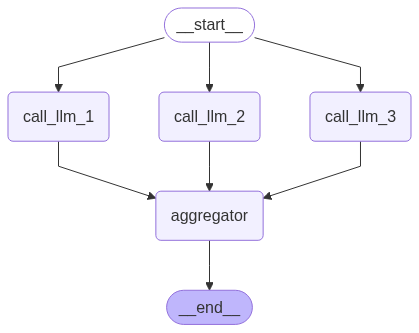

Here's a story, joke, and poem about cats!

STORY:
Whiskers, a sleek and agile cat, lived in a cozy house on a quiet street. She spent her days lounging in the sunbeams that streamed through the windows, chasing the occasional fly, and purring contentedly.

One day, while exploring the house, Whiskers stumbled upon a hidden door. She had never seen it before, and her curiosity was piqued. She padded softly towards the door, her tail twitching with excitement.

As she reached out a paw to touch the door, a warm, golden light spilled out, illuminating the dark hallway. Whiskers' eyes grew wide with wonder as she realized that this door led to a magical realm.

She stepped through the doorway and found herself in a fantastical land, filled with towering catnip plants, glittering gemstones, and sparkling fountains. The air was filled with the sweet scent of cat treats, and Whiskers' ears perked up as she heard the soft hum of happy cats.

As she explored this new world, Whiskers encountere

In [50]:
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str


# Nodes
def call_llm_1(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def call_llm_2(state: State):
    """Second LLM call to generate story"""

    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}


def call_llm_3(state: State):
    """Third LLM call to generate poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}


def aggregator(state: State):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}


# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()

# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = parallel_workflow.invoke({"topic": "cats"})
print(state["combined_output"])

### Routing
Routing classifies an input and directs it to a specialized followup task. This workflow allows for separation of concerns, and building more specialized prompts. Without this workflow, optimizing for one kind of input can hurt performance on other inputs.

When to use this workflow: Routing works well for complex tasks where there are distinct categories that are better handled separately, and where classification can be handled accurately, either by an LLM or a more traditional classification model/algorithm.

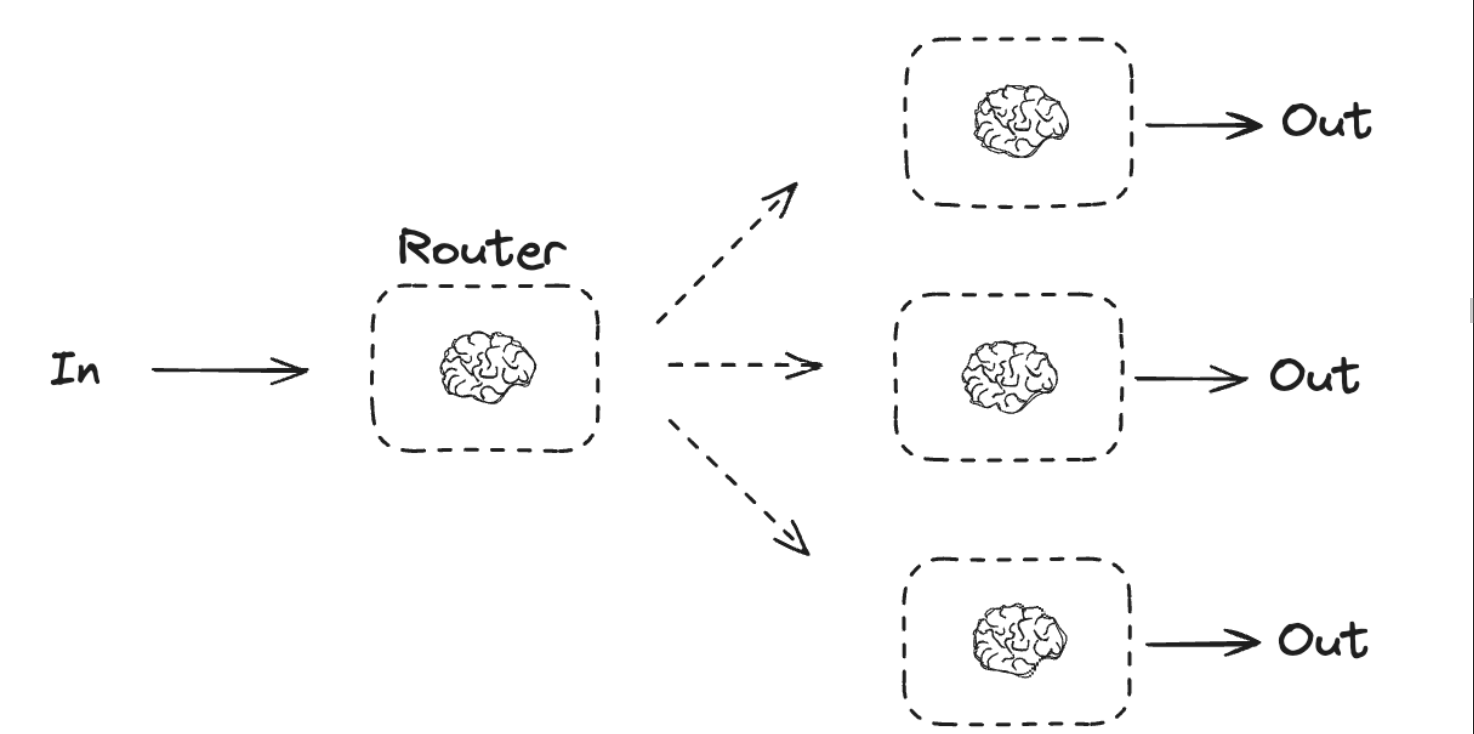

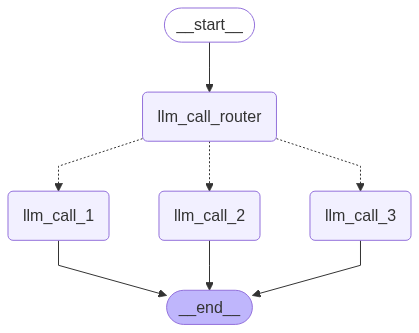

LLM call 2 is called
Why did the cat join a band?

Because it wanted to be the purr-cussionist!


In [53]:
from typing_extensions import Literal
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage


# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process"
    )


# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)


# State
class State(TypedDict):
    input: str
    decision: str
    output: str


# Nodes
def llm_call_1(state: State):
    """Write a story"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_2(state: State):
    """Write a joke"""

    print("LLM call 2 is called")

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_3(state: State):
    """Write a poem"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request."
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step}


# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"


# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = router_workflow.invoke({"input": "Write me a joke about cats"})
print(state["output"])

### Orchestrator-Worker
In the orchestrator-workers workflow, a central LLM dynamically breaks down tasks, delegates them to worker LLMs, and synthesizes their results.

When to use this workflow: This workflow is well-suited for complex tasks where you can’t predict the subtasks needed (in coding, for example, the number of files that need to be changed and the nature of the change in each file likely depend on the task). Whereas it’s topographically similar, the key difference from parallelization is its flexibility—subtasks aren't pre-defined, but determined by the orchestrator based on the specific input.
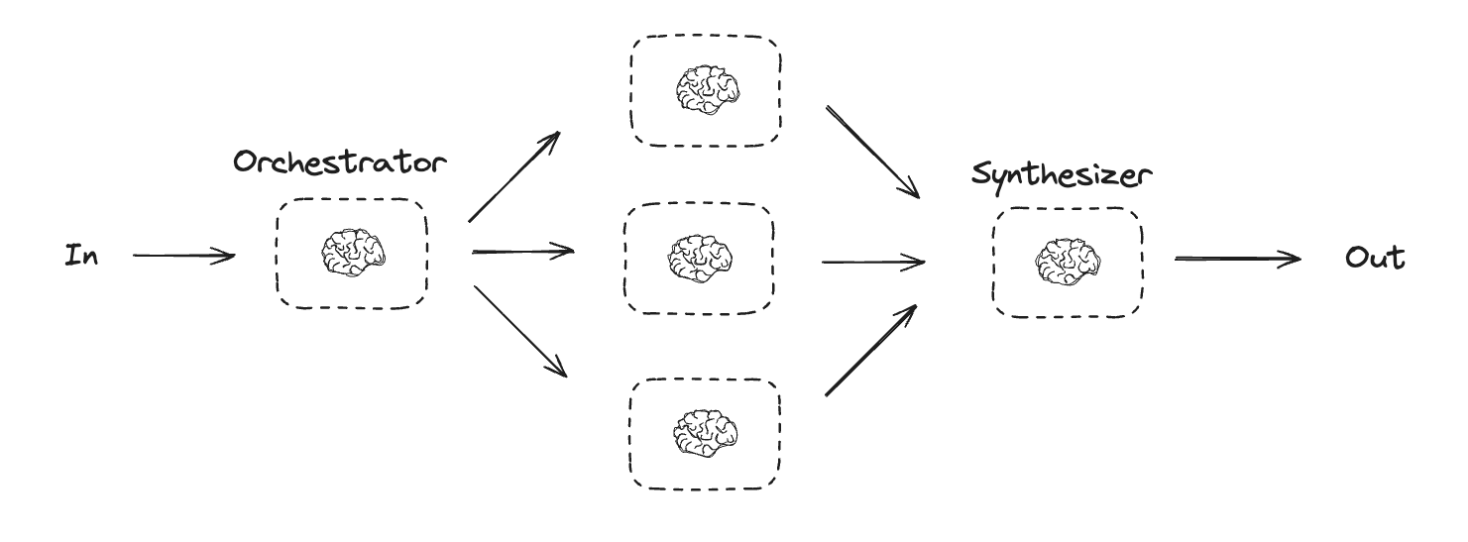

In [54]:

from typing import Annotated, List
import operator


# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

### Creating Workers in LangGraph

Because orchestrator-worker workflows are common, LangGraph has the Send API to support this. It lets you dynamically create worker nodes and send each one a specific input. Each worker has its own state, and all worker outputs are written to a shared state key that is accessible to the orchestrator graph. This gives the orchestrator access to all worker output and allows it to synthesize them into a final output. As you can see below, we iterate over a list of sections and Send each to a worker node. 

In [55]:
from langgraph.constants import Send


# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report

# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]

# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    print("Report Sections:",report_sections)

    return {"sections": report_sections.sections}

def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]


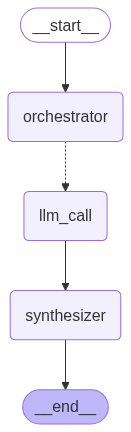

Report Sections: sections=[Section(name='Introduction to Information Warfare', description='Overview of the modern era of information warfare'), Section(name='History of Information Warfare', description='Brief history of information warfare'), Section(name='Types of Information Warfare', description='Types of information warfare, including cyberwarfare, psychological operations, and propaganda'), Section(name='Case Studies', description='Case studies of notable information warfare operations'), Section(name='Conclusion', description='Conclusion and implications of the modern era of information warfare')]


**Introduction to Information Warfare**
=============================

The modern era of information warfare has evolved significantly since the early days of cyber warfare. Today, information warfare encompasses a broad range of activities, including cyber attacks, electronic warfare, psychological operations, and information operations. The primary goal of information warfare is to affect the decision-making process of adversaries, creating an advantage over them. This can be achieved by disrupting or denying access to critical information, or by manipulating the information itself.

In the modern era, information warfare is no longer limited to nation-states. Non-state actors, such as terrorist organizations and criminal groups, have also become major players in the information domain. The proliferation of social media, the Internet of Things (IoT), and artificial intelligence (AI) have further expanded the scope of information warfare. The blurred lines between the physical and cyber domains have created new challenges for governments, militaries, and organizations to defend against information warfare attacks.

The importance of understanding information warfare lies in its ability to influence the outcome of conflicts, which can have significant consequences for national security, and societal stability. As the nature of warfare continues to evolve, it is essential to develop effective strategies, tactics, and technologies to counter the threats posed by information warfare**

*   **Cyber Warfare**: The use of digital technologies to disrupt or destroy an enemy's information systems.
*   **Electronic Warfare**: The use of electromagnetic energy to disrupt or destroy an enemy's electronic systems.
*   **Psychological Operations**: The use of information to influence the emotions, motives, and objective reasoning of an adversary.
*   **Information Operations**: The integrated employment of information-related capabilities to achieve a specific objective.

In the following sections, we will delve deeper into the various aspects of information warfare, including its history, tactics, technologies, and strategies employed by different actors. We will also explore the challenges and opportunities presented by information warfare and discuss the ways to develop effective countermeasures.

---

### History of Information Warfare
Information warfare has its roots in ancient times, with evidence of psychological and informational operations dating back to ancient Greece and Rome. In the 5th century BC, the Greek historian Herodotus wrote about the use of deception and disinformation in warfare. Similarly, the Roman Empire used propaganda and psychological operations to influence the outcome of battles.

In the modern era, information warfare began to take shape in the 1960s and 1970s, with the development of electronic warfare and signals intelligence. During the Cold War, the United States and the Soviet Union engaged in a series of covert information operations, including propaganda and disinformation campaigns.

The 1990s saw the emergence of cyber warfare, with the first reported cyber attack in 1998. Since then, information warfare landscape has continued to evolve, driven by advances in technology and the proliferation of the internet. Today, information warfare is recognized as a key component of modern military doctrine, with many countries investing heavily in information warfare capabilities.

Some notable examples of information warfare include:

* The 1980s-era "Operation Infektion", in which the KGB planted false stories about the origins of HIV/AIDS in the international press
* The 2008 cyber attacks on Georgia, which were attributed to Russian hackers
* The 2014 Sony Pictures hack, which was attributed to North Korean hackers
* The 2016 US presidential election, in which Russian hackers and propagandists sought to influence the outcome
* The ongoing cyber war between Ukraine and Russia, which has seen widespread use of cyber attacks and disinformation campaigns.

---

**Types of Information Warfare**
===============

### Cyberwarfare

Cyberwarfare involves the use of digital technologies to disrupt, destroy, or gain unauthorized access to an adversary's computer systems, networks, or infrastructure. This can include hacking, cyber espionage, distributed denial-of-service (DDoS) attacks, and other forms of cyber attacks. Cyberwarfare can be used to steal sensitive information, compromise critical infrastructure, or disrupt command and control systems.

### Psychological Operations

Psychological operations (PSYOP) involve the use of information warfare that targets the emotions, motivations, and beliefs of an adversary's population or military personnel. PSYOP can include propaganda, disinformation, and other forms of psychological manipulation. The goal of PSYOP is to influence the behavior, attitudes, and decision-making processes of the adversary, ultimately undermining their will to fight or resist.

### Propaganda

Propaganda involves the use of information, especially of a biased or misleading kind, to promote a particular political cause or point of view. Propaganda can take many forms, including print, radio, television, social media, and other forms of mass communication. The goal of propaganda is to shape public opinion, influence policy decisions, and promote a particular ideology or worldview.

Each of these types of information warfare can be used alone or in combination with others to achieve strategic objectives. Understanding the different types of information warfare is essential for developing effective countermeasures and strategies to mitigate their impact.

---

### Case Studies
#### Operation Moonlight Sonata
In 2007, the Russian Federation launched a series of cyber attacks against Estonia, a NATO member country. The attacks, which Estonian government websites and financial institutions were targeted, were orchestrated by Russian hackers and patriots. The attacks were in response to Estonia's decision to remove a Soviet-era war memorial from the capital city of Tallinn. The operation demonstrated the ability of a nation-state to use cyber warfare as a means of exerting political pressure on another country.

#### Stuxnet Worm
In 2010, a highly sophisticated computer worm, known as Stuxnet, was discovered to have infected industrial control systems at the Natanz uranium enrichment plant in Iran. The worm, which was designed to disrupt the operation of the plant, is widely believed to have been created by the United States and Israel as part of a covert operation to disrupt Iran's nuclear program. The Stuxnet worm is considered one of the most complex and sophisticated cyber weapons ever developed, and its deployment marked a significant escalation of cyber warfare capabilities.

#### Operation Orchard
In 2009, the Israeli military launched a cyber attack against Syria's air defense system, disabling it and allowing Israeli warplanes to bomb a suspected nuclear reactor site. The operation, code-named Operation Orchard, demonstrated the ability of a nation-state to use cyber warfare as a means of gaining a strategic advantage in a military operation.

#### NotPetya Attack
In 2017, a cyber attack, known as NotPetya, was launched against Ukraine, causing widespread disruption to the country's critical infrastructure, including its power grid, financial system, and transportation networks. The attack, which was attributed to Russia, was designed to look like a ransomware attack, but its true purpose was to disrupt Ukraine's economy and infrastructure. The NotPetya attack demonstrated the ability of a nation-state to use cyber warfare as a means of exerting economic pressure on another country.

---

### Conclusion and Implications of the Modern Era of Information Warfare
============================================================

The advent of information warfare has revolutionized the way nations conduct warfare. The modern era of information warfare has brought about a paradigm shift in the way conflicts are fought, won, and lost. The rise of social media, cyber-attacks, and disinformation campaigns has created a new battleground where nations can engage in covert operations, influencing public opinion, and disrupting critical infrastructure.

The implications of this new era of information warfare are far-reaching. Nations must now invest heavily in developing their cyber capabilities, both defensive and offensive, to protect themselves from the ever-evolving threats. The blurred lines between military and civilian targets have made it essential for governments to educate their citizens on the risks associated with information warfare.

Furthermore, the lack of clear international norms and regulations governing information warfare has created a Wild West scenario, where nations operate with impunity. This has led to a significant increase in the number of cyber-attacks, disinformation campaigns, and other forms of information warfare.

In conclusion, the modern era of information warfare poses significant challenges to national security, democratic institutions, and global stability. It is essential for nations to come together to establish clear norms, regulations, and consequences for violating them. The development of robust cyber capabilities, and awareness among citizens are critical in this fight against the unseen enemy.

In [57]:
# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on Mordern era of information warfare"})

from IPython.display import Markdown
Markdown(state["final_report"])

### Evaluator-optimizer
In the evaluator-optimizer workflow, one LLM call generates a response while another provides evaluation and feedback in a loop.

When to use this workflow: This workflow is particularly effective when we have clear evaluation criteria, and when iterative refinement provides measurable value. The two signs of good fit are, first, that LLM responses can be demonstrably improved when a human articulates their feedback; and second, that the LLM can provide such feedback. This is analogous to the iterative writing process a human writer might go through when producing a polished document.

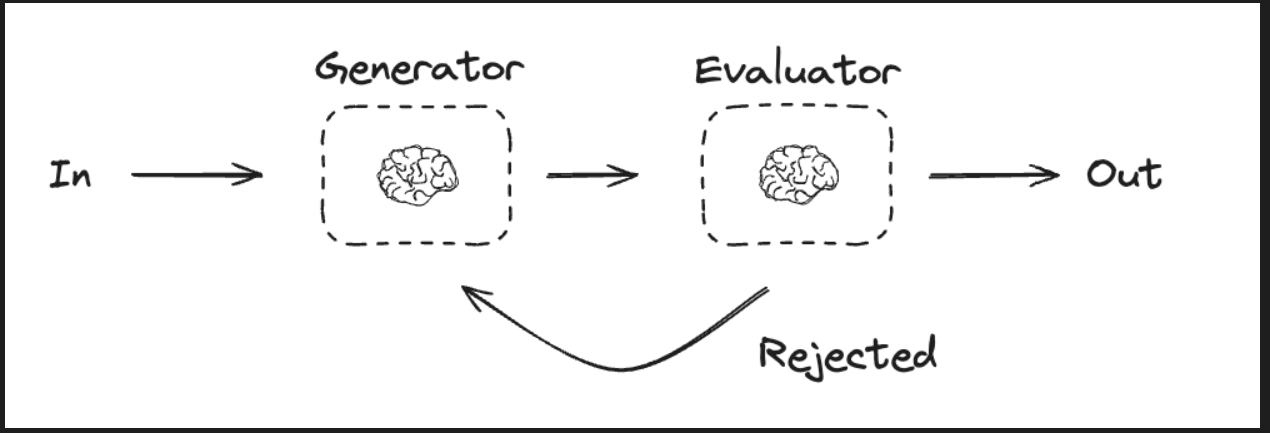

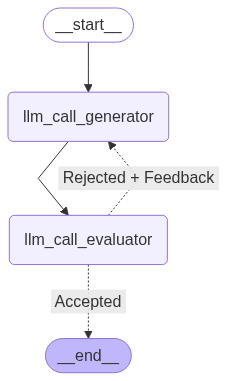

Why did the cat join a band?

Because it wanted to be the purr-cussionist!


In [60]:
# Graph state
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str


# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it.",
    )


# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)


# Nodes
def llm_call_generator(state: State):
    """LLM generates a joke"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def llm_call_evaluator(state: State):
    """LLM evaluates the joke"""

    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}


# Conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"


# Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# Add edges to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {  # Name returned by route_joke : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile()

# Show the workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = optimizer_workflow.invoke({"topic": "Cats"})
print(state["joke"])